# **CONTEXT**

**Company Name:** Insurance All

**Product/Service:** Offer Health Insurance

**Business Model:** An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

**Current Situation:** Now they want to offer a car insurance. Last year they did a research with their 380 thousand customers about their interest in getting a car insurance, and the results has been storage in a database together with others customers attributes.
The product team selected 127 thousand new customers to participate in a marketing campaing that will be offering the new car insurance to them. The campaing will be made through phone calls by the sales team.

**Problem:** The problem is that the sales team has capacity of making only 20 thousand calls on the period the campaing will be running.

**Proposed Solution:** Predict the likelihood of the customer of getting the car insurance so that the sales team can prioritize which customer to call to have a better conversion rate.

**Deliverables:** A report answering the following questions:

   **1.** Main insights of the most relevant attributes of the customers interested in getting the car insurance;
    
   **2.** Percentage of interested customers the sales team will be able to call with 20.000 calls;
    
   **3.** Percentage of interested customers the sales team will be able to call with 40.000 calls;
    
   **4.** How many calls the sales team have to make to reach 80% of the interested customers.

# IMPORTS

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import statistics as st
from scipy      import stats
from scipy.stats import chi2_contingency

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn import svm

# General Utilities
import pickle
import warnings
warnings.filterwarnings('ignore')

# Database Library
import psycopg2

# General Utilities
from IPython.display import Image

# HELPER FUNCTIONS

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 )*( r-1 )/( n-1 ) )
    
    kcorr = k - ( k-1 )**2/( n-1 )
    rcorr = r - ( r-1 )**2/( n-1 )
    
    return np.sqrt( ( chi2corr/n ) / ( min(kcorr-1, rcorr-1) ) )


def prediction_score(model, data):
    # Separating train and validation dataset for each kfold
    x_train = data.drop(columns=['response'])
    y_train = data['response']
    
    # prediction probability (score)
    yhat_proba = model.predict_proba(x_train)[:, 1].tolist()
    
    # merging score to dataset
    data_scored = data.copy()
    data_scored['score'] = yhat_proba
    
    # sort
    data_scored = data_scored.sort_values('score', ascending=False)
    
    # precision and recall
    data_scored = data_scored.reset_index(drop=True)
    data_scored['n_samples'] = data_scored.index + 1
    data_scored['precision_at_k'] = data_scored['response'].cumsum() / data_scored['n_samples']
    data_scored['recall_at_k'] = data_scored['response'].cumsum() / data_scored['response'].sum()
    
    return data_scored

def cross_validation(kfold, modelName, model, data, at_k):
    # Number of folds
    fold=ms.StratifiedKFold(n_splits = kfold, shuffle=True, random_state=42)
    
    # Performance variables
    precision_list = []
    recall_list = []
    cv_performance = {}
    
    for train_cv,val_cv in fold.split(data, data['response']):
        
        # Separating train and validation dataset for each kfold
        # training data
        x_train_fold = data.iloc[train_cv]
        x_train_fold = x_train_fold[cols_selected]
        
        y_train_fold = data['response'].iloc[train_cv]
        
        # validation data
        x_val_fold = data.iloc[val_cv]
        x_val_fold = x_val_fold[cols_selected]
        
        y_val_fold = data['response'].iloc[val_cv]
        
        # fitting the model
        model_fitted = model.fit(x_train_fold,y_train_fold)
        
        # getting the prediction probability
        x_val_fold['response'] = y_val_fold
        val_scored = prediction_score(model_fitted, x_val_fold)
        
        # Getting precision and recall at k
        precision = val_scored.loc[at_k, 'precision_at_k']
        recall = val_scored.loc[at_k, 'recall_at_k']
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    # calculating the mean and std performance of all kfolds
    precision_cv = np.round(np.mean(precision_list),4).astype(float)
    std_precision_cv = '+/-' + np.round(np.std(precision_list),4).astype(str)
    recall_cv = np.round(np.mean(recall_list),4).astype(float)
    std_recall_cv = ' +/- ' + np.round(np.std(recall_list),4).astype(str)
        
    cv_performance[modelName] = [precision_cv, std_precision_cv, recall_cv, std_recall_cv]
    model_performance_cv = pd.DataFrame(cv_performance, index=['precision_at_k', 'std_precision', 'recall_at_k', 'std_recall'])

    return model_performance_cv



In [3]:
# Notebook Configurations
sns.set_theme()


# BUSINESS RESEARCH

https://www.relakhs.com/insurance-companies-business-model/

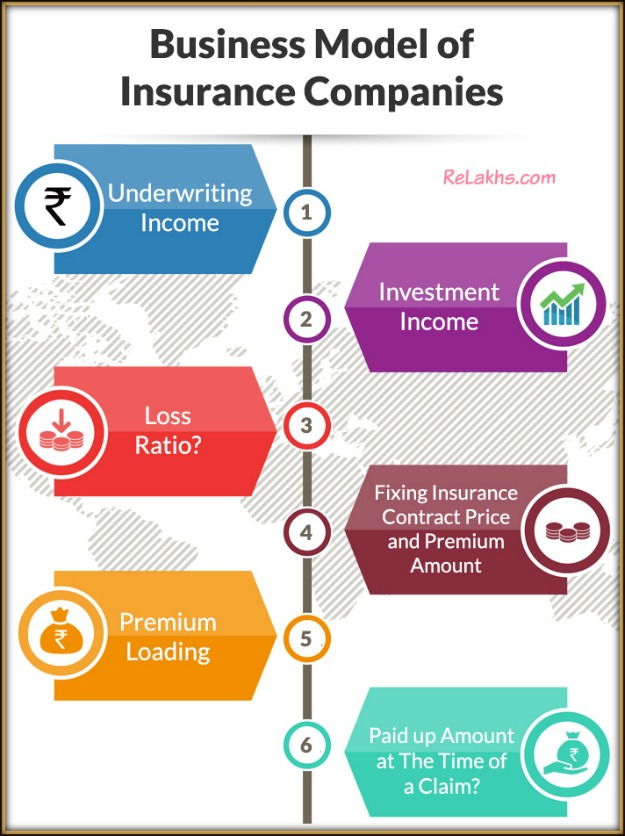

In [4]:
Image('images/business-model-of-insurance-companies-pic.jpeg')

# 1.0. SOLUTION PLANNING

- Build a Classification model to calculate the likelihood of customers interested in car insurance, then we are going to sort them to select the customers more likely to be interested in car insurance. For that we will do the following steps:
    - Data Collecting: from the Database;
    - Descriptive analysis:  see how the data is. (To see how much work needs to be done processing the data.)
    - Exploratory Data Analisys:  see the behavior of the data (features).
    - Data Preparation: Preparating data to fit into machine learning model;
    - Implementation of machine learning models;
    - Interpretation of the metrics of the model;
    - Translating the model metrics to business metrics;
    - Deploy of the model to production;
 

## 1.1. Main insights of the most relevant attributes of the customers interested in getting the car insurance;

- Compare the data between those that are interested and those that are not interested through EDA;
- See if there are any insight. (different behavior in datas)

## 1.2. Percentage of interested customers the sales team will be able to call with 20.000 calls;

- Build a classification model to score the probability of customers tha have interest in car insurance.
- Sort the list of customers from the highest to lowest score.
- Calculate the percentage of customers that have interest in car insurance in the top 20.000 customers from the sorted list

## 1.3. Percentage of interested custumers the sales team will be able to call with 40.000 calls;

- Same as 1.2.

## 1.4. How many calls the sales team have to make to reach 80% of the interested custumers.

- After calculating the total number of customers interested in getting car insurance, we can calculate how many calls would be necessary to reach 80% of those customers.

# 2.0. GETTING THE DATA FROM DATABASE

In [4]:
# Credentials of the Database
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

# Connecting to Database
conn = psycopg2.connect(host=host, port=port, database=database, user=username, password=password)

# Cursor
cursor = conn.cursor()

In [5]:
# Listing Schemas
cursor.execute("SELECT nspname FROM pg_catalog.pg_namespace;")
print (cursor.fetchall())

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


In [6]:
# Showing tables from Database
cursor.execute("SELECT tablename FROM pg_tables WHERE schemaname='pa004';")
print (cursor.fetchall())

[('users',), ('vehicle',), ('insurance',)]


In [7]:
# query all data from tables (users, vehicle, insurance)
query_tables = """SELECT * FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                                              LEFT JOIN pa004.insurance i ON (u.id = i.id)"""

df_raw_tables = pd.read_sql(query_tables, conn)

# closing cursor and connection
cursor.close()
conn.close()

In [8]:
# Checking the dataframe
df_raw_tables.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [9]:
# Removing duplicated id columns
df_raw_tables = df_raw_tables.loc[:,~df_raw_tables.columns.duplicated()]
df_raw_tables.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## Checkpoint

In [10]:
# Saving Raw Dataset collected from database
df_raw_tables.to_csv('../Data/df_raw.csv', sep=';', index_label=False)

# 3.0. DESCRIPTIVE ANALYSIS

In [11]:
# Loading raw dataset
df3 = pd.read_csv('../Data/df_raw.csv', sep=';')

## 3.1. Data Dimension and Feature Description

In [4]:
print(f'There are {df3.shape[0]} rows')
print(f'There are {df3.shape[1]} columns')

There are 381109 rows
There are 12 columns


In [5]:
# Description of variables
variables = {'id': 'Unique ID for the customer',
             'gender': '(Male or Female)',
             'age': 'Age of the customer',
             'region_code': 'Unique code for the region of the customer',
             'policy_sales_channel': 'Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.', 
             'driving_license': '0 : Customer does not have DL, 1 : Customer already has DL',
             'vehicle_age': '< 1 Year, 1-2 Year, > 2 Years',
             'vehicle_damage': "Yes or No",
             'previously_insured': "1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance",
             'annual_premium': 'The amount customer needs to pay as premium in the year',
             'vintage': 'Number of Days, Customer has been associated with the company',
             'response': '1 : Customer is interested, 0 : Customer is not interested'}


pd.set_option('display.max_colwidth', -1);
pd.DataFrame.from_dict(variables, orient='index', columns=['description'])

,description
id,Unique ID for the customer
gender,(Male or Female)
age,Age of the customer
region_code,Unique code for the region of the customer
policy_sales_channel,"Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc."
driving_license,"0 : Customer does not have DL, 1 : Customer already has DL"
vehicle_age,"< 1 Year, 1-2 Year, > 2 Years"
vehicle_damage,Yes or No
previously_insured,"1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance"
annual_premium,The amount customer needs to pay as premium in the year


## 3.1. Checking NA

In [6]:
df3.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

No missing values in the dataset

## 3.2. Checking Data Types

In [7]:
df3.dtypes

id                      int64  
gender                  object 
age                     int64  
region_code             float64
policy_sales_channel    float64
driving_license         int64  
vehicle_age             object 
vehicle_damage          object 
previously_insured      int64  
annual_premium          float64
vintage                 int64  
response                int64  
dtype: object

## 3.3. Descriptive Statistics

### 3.3.1. Target Attribute

In [9]:
df3['response'].value_counts()

0    334399
1    46710 
Name: response, dtype: int64

In [10]:
df3['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

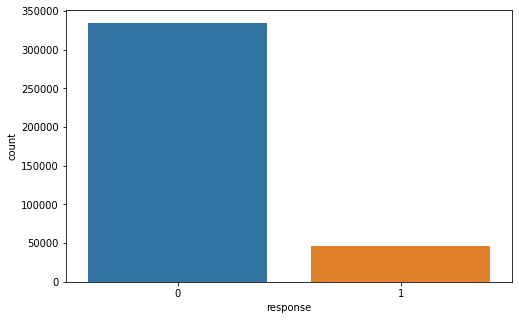

In [11]:
plt.figure(figsize=[8, 5])
sns.countplot(data=df3, x='response');

So there are only 12.25% of the target attribute that has interest in car insurance.

This shows us that the data is imbalanced.

### 3.3.2 Numerical Attributes

In [15]:
# Separating numeric features
num_attributes = df3[['age', 'annual_premium', 'vintage']]

# Calculating statistics
descrip_stats_num = num_attributes.describe()

# mode
descrip_stats_num.loc['mode'] = df3.apply(lambda x: st.mode(x))

# range
descrip_stats_num.loc['range'] = descrip_stats_num.loc['max'] - descrip_stats_num.loc['min']

# skew
descrip_stats_num.loc['skew'] = df3.skew()

# kurtosis
descrip_stats_num.loc['kurtosis'] = df3.kurtosis()


descrip_stats_num.reindex(['count',
                           'min',
                           '25%',
                           '50%',
                           '75%',
                           'max',
                           'range',
                           'std',
                           'mean',
                           'mode',
                           'skew',
                           'kurtosis']).T

,count,min,25%,50%,75%,max,range,std,mean,mode,skew,kurtosis
age,381109.0,20.0,25.0,36.0,49.0,85.0,65.0,15.511611,38.822584,24.0,0.672539,-0.565655
annual_premium,381109.0,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,17213.155057,30564.389581,2630.0,1.766087,34.004569
vintage,381109.0,10.0,82.0,154.0,227.0,299.0,289.0,83.671304,154.347397,256.0,0.003030,-1.200688


- Key points:
    - Min age of customers is 20, max is 85 and mean is 38 years;
    - annual_premium min is 2,630, max is 540,165 and mean is 30,564;
    - Min of vintage is 10 days and mean is 154 days;
    - Annual_premium has a range of 537,535

### 3.3.3. Categorical Attributes

In [103]:
cat_attributes = df3[['gender',
                      'region_code',
                      'policy_sales_channel',
                      'driving_license',
                      'vehicle_age',
                      'vehicle_damage',
                      'previously_insured']]

descrip_stats_cat_dict = {}

for c in cat_attributes.columns:
    descrip_stats_cat_dict[c] = {'unique': int(len(cat_attributes[c].unique())),
                                 'top': cat_attributes[c].value_counts().idxmax(),
                                 'top_freq': int(cat_attributes[c].value_counts().max()),
                                 'top_freq%': round(cat_attributes[c].value_counts(normalize=True).max()*100,2)}
    
pd.DataFrame(descrip_stats_cat_dict)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured
unique,2,53.00,155.00,2.00,3,2,2.00
top,Male,28.00,152.00,1.00,1-2 Year,Yes,0.00
top_freq,206089,106415.00,134784.00,380297.00,200316,192413,206481.00
top_freq%,54.08,27.92,35.37,99.79,52.56,50.49,54.18


- Key points:
    - 54.08% of customers are male;
    - 27.92% of customers are from region code 53;
    - 35.37% of customers outreached through policy_sales_channel 152;
    - 99.79% of customers have driving license;
    - 52.56% of cars have 1-2 Year old;
    - 50.49% of customers have their car damaged before;
    - 54.18% of customers were previously insured before.

# 4.0. FEATURE ENGINEERING

In [282]:
# loading raw dataset
df4 = pd.read_csv('Data/df_raw.csv', sep=';')

## 4.1. Mind Map Hypotesis

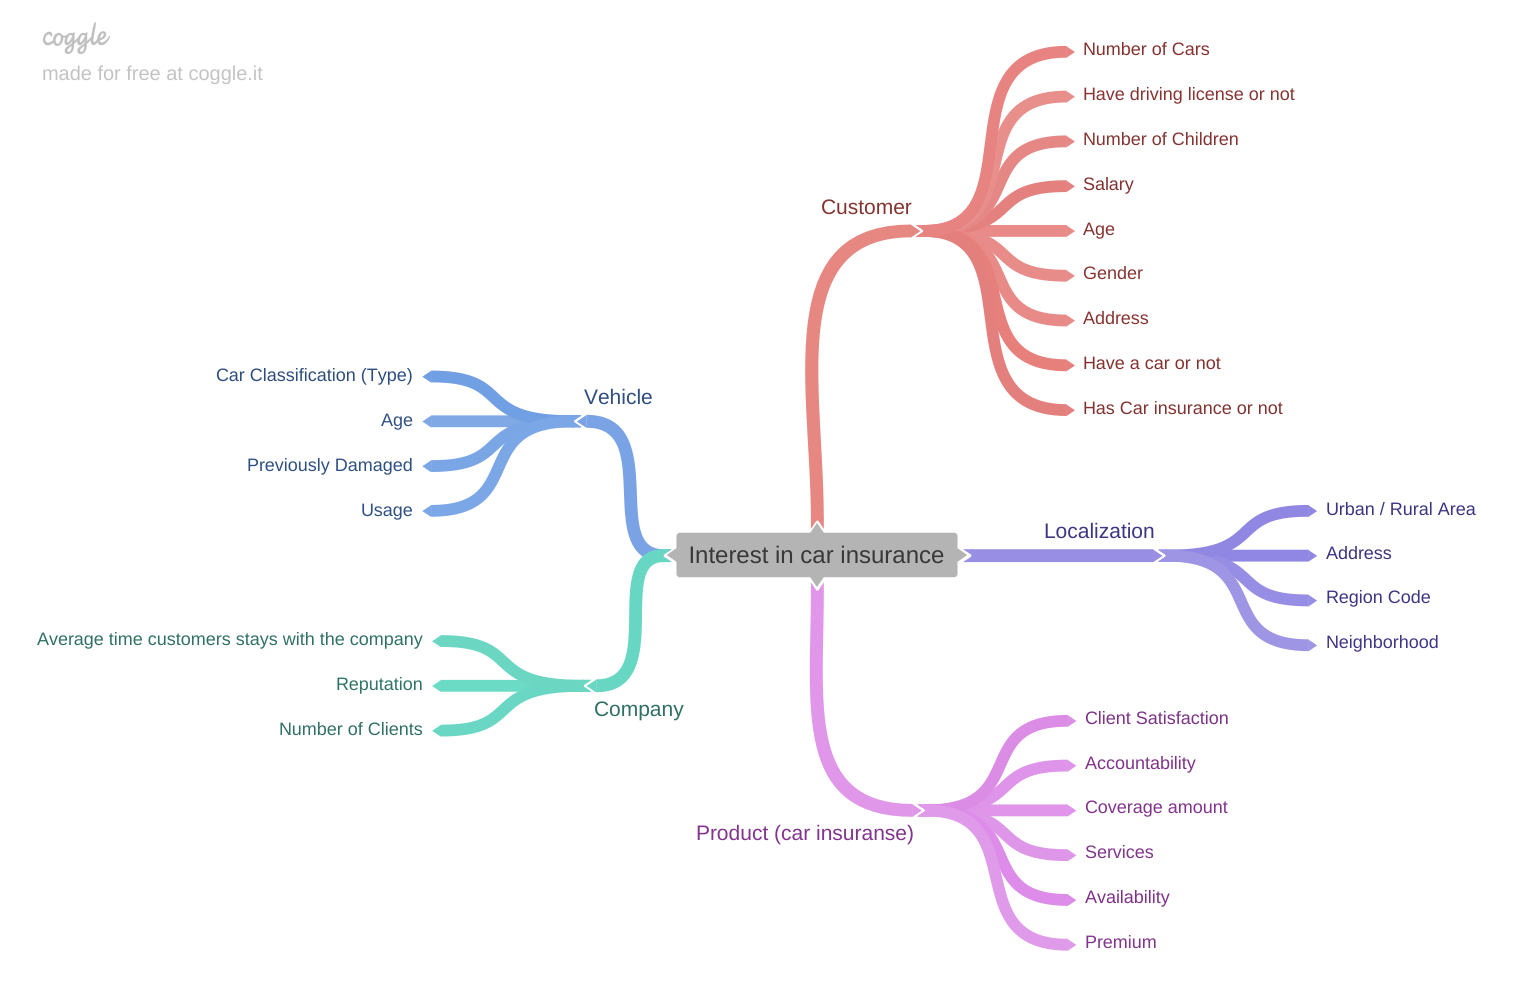

In [15]:
Image('images/mindmaphypotesis.png')

## 4.2. Hypothesis Creation

**Vehicle Hypotesis**

1. Customer that has car with better classification (eg: pickups, SUV) are more likely to be interested in car insurance

2. Customers that has new car are more likely to be insterested in car insurance

3. Customers that has car that have been previously damaged are more likely to be interested in car insurance

4. Customers that uses the car to work (eg: taxi, delivery, uber) are more likely to be interested in car insurance

**Company Hypothesis**

5. Customers are more likely to be interested in car insurance if the rating/avaliation (by customers) is higher/better

6. Customers are more likely to be interested in car insurance if the company have a big number of customers

**Customer Hypothesis**

7. Customers that are client for longer are more likely to be interested in car insurance

8. Customers that have more cars are more likely to be interested in car insurance

9. Customers that have driving license are more likely to be interested in car insurance

10. Customers that have more children are more likely to be interested in car insurance

11. Customers that have bigger salary are more likely to be interested in car insurance

12. Older customers are more likely to be interested in car insurance

13. Female customers are more likely to be interested in car insurance

14. Customers that have a car are more likely to be interested in car insurance

15. Customers that do not have a car insurace previously are more likely to be interested in car insurance

**Localization Hypothesis**

16. Customers that lives in urban areas are more likely to be interested in car insurance

17. Customers that lives in violent neighborhood are more likely to be interested in car insurance

18. Customers that lives in regions with higher average annual premium are more likely to be interested in car insurance

19. Customers that lives in region where that are more damaged vehicles are more likely to be interested in car insurance

**Product (car insurance) Hypotesis**

20. Customers are more likely to be interested in car insurance the bigger the coverage amount (R$)

21. Customers are more likely to be interested in car insurance if the service is good

22. Customers are more likely to be interested in car insurance the lower the premium (of health insurance)

## 4.3. Final Hypothesis List

**Vehicle Hypotesis**
1. Customers that has new car are more likely to be insterested in car insurance

2. Customers that has car that have been previously damaged are more likely to be interested in car insurance

**Customer Hypothesis**

3. Customers that are client for longer are more likely to be interested in car insurance

4. Customers that have driving license are more likely to be interested in car insurance

5. Older customers are more likely to be interested in car insurance

6. Female customers are more likely to be interested in car insurance

7. Customers that do not have a car insurace previously are more likely to be interested in car insurance

**Localization Hypothesis**

8. Customers that lives in regions with higher average annual premium are more likely to be interested in car insurance

9. Customers that lives in region where that are more damaged vehicles are more likely to be interested in car insurance

**Product (car insurance) Hypotesis**

10. Customers are more likely to be interested in car insurance the lower the premium (of health insurance)

## 4.4. Feature Engineering

In [283]:
# median_premium_by_region

# Calculating Median Annual Premium by Region_code
dict_region_code = df4[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']
dict_region_code

# Mapping region code to input median premium by region_code
df4['median_premium_by_region'] = df4['region_code'].map(dict_region_code)

In [284]:
# delta_annual_premium_by_region
df4['delta_premium_by_region'] = df4['annual_premium'] - df4['median_premium_by_region']

In [285]:
# vehicle_damage percentage by region_code

# percentage of vehicle_damage==1 by region_code
perc_region_code = {}
for i in df4['region_code'].unique():
    perc_region_code[i] = ((df4['vehicle_damage'] == 'Yes') & (df4['region_code'] == i)).sum() / (df4['region_code'] == i).sum()

# Mapping region code to input percentage of vehicle_damage == Yes
df4['vehicle_damage_region_code'] = df4['region_code'].map(perc_region_code)


In [286]:
# discretize age (adult 1, adult 2, )
df4['age_discretized'] = df4['age'].apply(lambda x: 'adult 1' if x<=39 else 
                                                    'adult 2' if x<=59 else
                                                    'old')

## Checkpoint

In [288]:
# saving data with feature engineering
df4.to_csv('../Data/df_fe.csv', sep=';', index_label=False)

# 5.0. EXPLORATORY DATA ANALYSIS

In [21]:
# loading dataset with feature engineering
df5 = pd.read_csv('../Data/df_fe.csv', sep=';')

## 5.1. Univariate Analysis

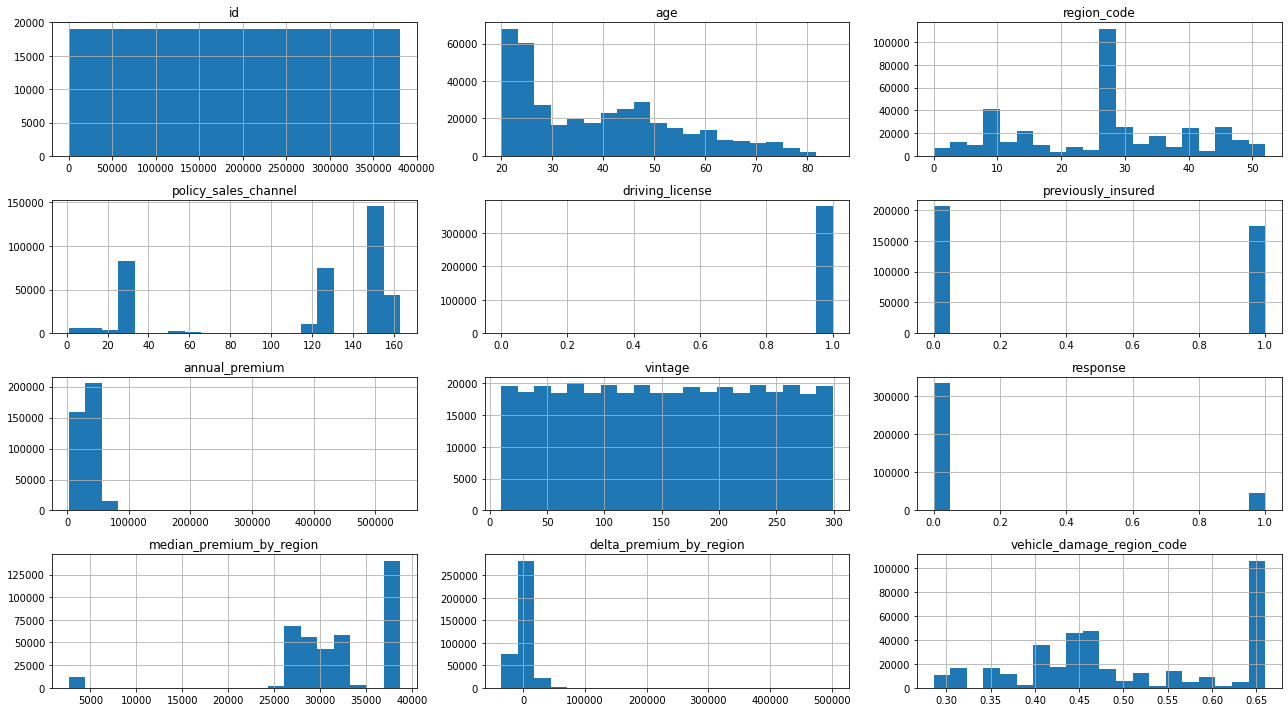

In [22]:
df5.hist(bins=20, figsize=(18,10));
plt.tight_layout()

## 5.2. Bivariate Analysis

The objective of this EDA is to see if the feature separate our data (hyperplane separation) correlating to the target variable.

### 1. Customers that have cars with <1 Year olf are more likely to be insterested in car insurance
**FALSE:** Customers that have older car (>2 Years older) are more likely to be interested in car insurance

In [23]:
# vehicle_age
pd.crosstab(df5['vehicle_age'], df5['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_age,,
1-2 Year,0.826245,0.173755
< 1 Year,0.956295,0.043705
> 2 Years,0.706254,0.293746


In [24]:
# cramer_v association

# separating columns to be tested
vehicle_age = df5['vehicle_age']
response = df5['response']

cramerv1 = cramer_v(vehicle_age, response)

print(f'cramer v: {cramerv1}')
print('The association between vehicle_age and response is week')

cramer v: 0.22193713044970043
The association between vehicle_age and response is week


Customers that have older cars are more likely to have insterest in car insuranse

### 2. Customers that have car that were previously damaged are more likely to be interested in car insurance
**TRUE:** Customers that have their car previously damaged are more likely to be interested in car insurance

In [25]:
# 'vehicle_damage'
pd.crosstab(df5['vehicle_damage'], df5['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_damage,,
No,0.994796,0.005204
Yes,0.762345,0.237655


In [26]:
# cramer_v association

# separating columns to be tested
vehicle_damage = df5['vehicle_damage']
response = df5['response']

cramerv2 = cramer_v(vehicle_damage, response)

print(f'cramer v: {cramerv2}')
print('The association between vehicle_damage and response is moderate')

cramer v: 0.35439200710199065
The association between vehicle_damage and response is moderate


Customers that have vehicle damaged before are more interested in car insurance

### 3. Customers that are client for longer (vintage >= 154) are more likely to be interested in car insurance
**FALSE:** There are no difference between newer or older clients and their interest in car insurance

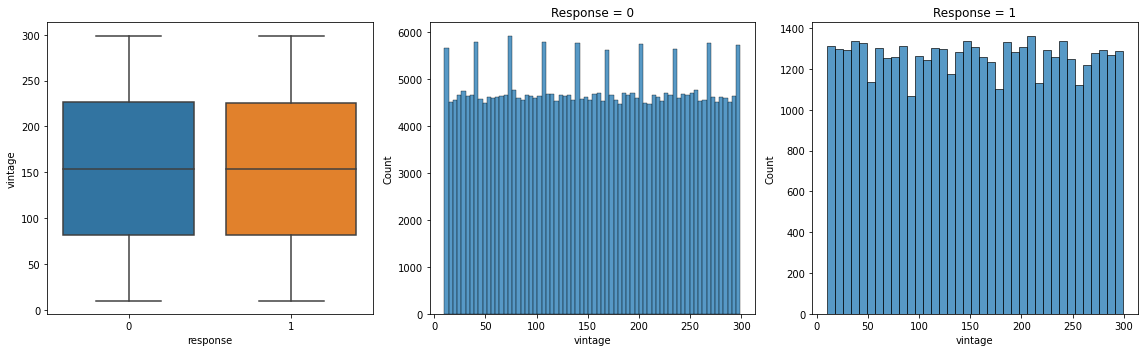

In [27]:
# 'vintage'
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='response', y='vintage', data=df5);

plt.subplot(1, 3, 2)
aux_vintage0 = df5.loc[df5['response'] == 0, 'vintage']
sns.histplot(aux_vintage0).set_title('Response = 0');

plt.subplot(1, 3, 3)
aux_vintage1 = df5.loc[df5['response'] == 1, 'vintage']
sns.histplot(aux_vintage1).set_title('Response = 1');

plt.tight_layout()

In [28]:
# Separating dataset by vintage >=154 and < 154

vintage_older = df5[df5['vintage']>=154]
vintage_newer = df5[df5['vintage']<154]

# percentage of response == 1 for each dataset
perc_vintage_older = round((vintage_older['response'] == 1).sum()/vintage_older.shape[0], 4)*100
perc_vintage_newer = round((vintage_newer['response'] == 1).sum()/vintage_newer.shape[0], 3)*100

print(f'Of older clients, {perc_vintage_older}% have interest in car insurance')
print(f'Of newer clients, {perc_vintage_newer}% have interest in car insurance')

Of older clients, 12.23% have interest in car insurance
Of newer clients, 12.3% have interest in car insurance


There are not much difference between older and newer customers in regard of there interest in car insuranse

### 4. Customers that have driving license are more likely to be interested in car insurance
**TRUE:** Customers that have driving license have more interest in car insurance

In [29]:
# 'driving_license'
pd.crosstab(df5['driving_license'], df5['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


In [30]:
# cramer_v association

# separating columns to be tested
driving_license = df5['driving_license']
response = df5['response']

cramerv4 = cramer_v(driving_license, response)

print(f'cramer v: {cramerv4}')
print('The association between driving_license and response is weak')

cramer v: 0.010068422910077413
The association between driving_license and response is weak


Although there are some difference in interest in car insurance of customer that have and does not have driving license, the association between these features is weak

### 5. Older customers (age >= 36) are more likely to be interested in car insurance
**TRUE:** Older clients have more interest in car insurance

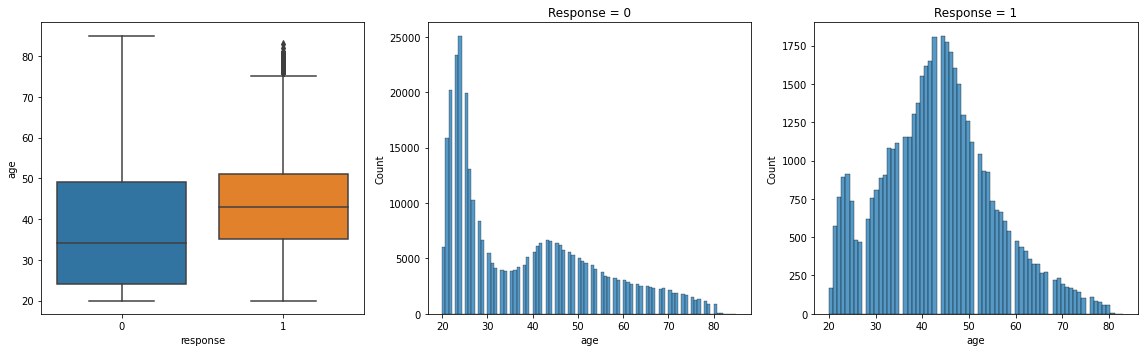

In [31]:
# 'age'
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='response', y='age', data=df5);

plt.subplot(1, 3, 2)
aux_age0 = df5.loc[df5['response'] == 0, 'age']
sns.histplot(aux_age0).set_title('Response = 0');

plt.subplot(1, 3, 3)
aux_age1 = df5.loc[df5['response'] == 1, 'age']
sns.histplot(aux_age1).set_title('Response = 1');

plt.tight_layout()

In [32]:
# Separating dataset by age >=36 and < 36

age_older = df5[df5['age']>=36]
age_newer = df5[df5['vintage']<36]

# percentage of response == 1 for each dataset
perc_age_older = round((age_older['response'] == 1).sum()/age_older.shape[0], 3)*100
perc_age_newer = round((age_newer['response'] == 1).sum()/age_newer.shape[0], 3)*100

print(f'Of older clients, {perc_age_older}% have interest in car insurance')
print(f'Of newer clients, {perc_age_newer}% have interest in car insurance')

Of older clients, 17.7% have interest in car insurance
Of newer clients, 12.4% have interest in car insurance


We can see that customers that are interested in car insurance, in average is older 

### 6. Female customers are more likely to be interested in car insurance
**FALSE:** Male customers have more interest in car insurance

In [33]:
# 'gender'
pd.crosstab(df5['gender'], df5['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


In [34]:
# cramer_v association

# separating columns to be tested
gender = df5['gender']
response = df5['response']

cramerv6 = cramer_v(gender, response)

print(f'cramer v: {cramerv6}')
print('The association between gender and response is weak')

cramer v: 0.05243195443576884
The association between gender and response is weak


Although there are some difference in interest in car insurance between male and female, the association between these features is weak

### 7. Customers that do not have a car insurace previously are more likely to be interested in car insurance
**TRUE:** customers that do not have car insurace previously have more interest in car insurance.

In [35]:
# 'previously_insured'
pd.crosstab(df5['previously_insured'], df5['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [36]:
# cramer_v association

# separating columns to be tested
previously_insured = df5['previously_insured']
response = df5['response']

cramerv7 = cramer_v(previously_insured, response)

print(f'cramer v: {cramerv7}')
print('The association between gender and response is moderate')

cramer v: 0.34116288076556345
The association between gender and response is moderate


Customers that weren't previously insured has more interest in car insurance

### 8. Customers that pays less annual premium than the median of the region are more likely to be interested in car insurance
**FALSE:** There are no difference in their interest in car insurance

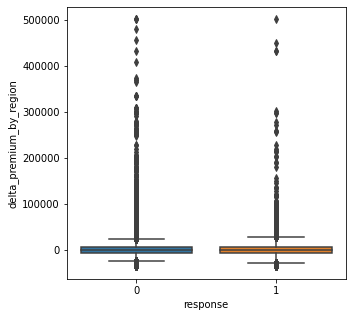

In [38]:
# 'delta_premium_by_region'
plt.figure(figsize=(5, 5))
sns.boxplot(x='response', y='delta_premium_by_region', data=df5);

In [39]:
# Separating dataset by median_premium_region_code >=31672 and < 31672

delta_premium_by_region_higher = df5[df5['delta_premium_by_region']>=0]
delta_premium_by_region_lower = df5[df5['delta_premium_by_region']<0]

# percentage of response == 1 for each dataset
perc_delta_premium_by_region_higher = round((delta_premium_by_region_higher['response'] == 1).sum()/delta_premium_by_region_higher.shape[0], 3)*100
perc_delta_premium_by_region_lower = round((delta_premium_by_region_lower['response'] == 1).sum()/delta_premium_by_region_lower.shape[0], 2)*100

print(f'{perc_delta_premium_by_region_higher}% of customers that pays more premium than the median of the region, have interest in car insurance')
print(f'{perc_delta_premium_by_region_lower}% of customers that pays less premium than the median of the region, have interest in car insurance')

12.2% of customers that pays more premium than the median of the region, have interest in car insurance
12.0% of customers that pays less premium than the median of the region, have interest in car insurance


### 9. Customers that lives in region where that are more damaged vehicles are more likely to be interested in car insurance
**TRUE:** Customers that lives in region where the percentage of damaged vehicles >= 45,86%, have more interest in car insurance.

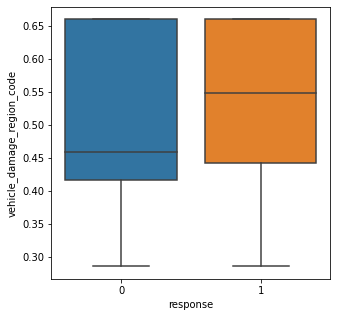

In [40]:
# 'vehicle_damage_region_code'
plt.figure(figsize=(5, 5))
sns.boxplot(x='response', y='vehicle_damage_region_code', data=df5);

In [41]:
# Separating dataset by vehicle_damage_region_code >=0.4586 and < 0.4586

vehicle_damage_region_code_higher = df5[df5['vehicle_damage_region_code']>=0.4586]
vehicle_damage_region_code_lower = df5[df5['vehicle_damage_region_code']<0.4586]

# percentage of response == 1 for each dataset
perc_vehicle_damage_region_code_higher = round((vehicle_damage_region_code_higher['response'] == 1).sum()/vehicle_damage_region_code_higher.shape[0], 4)*100
perc_vehicle_damage_region_code_lower = round((vehicle_damage_region_code_lower['response'] == 1).sum()/vehicle_damage_region_code_lower.shape[0], 4)*100

print(f'{perc_vehicle_damage_region_code_higher}% of customers have interest in car insurance where there are more damaged vehicles')
print(f'{perc_vehicle_damage_region_code_lower}% of customers have interest in car insurance where there are fewer damaged vehicles')

14.45% of customers have interest in car insurance where there are more damaged vehicles
9.27% of customers have interest in car insurance where there are fewer damaged vehicles


### 10. Customers are more likely to be interested in car insurance the lower the premium (of health insurance)
**FALSE:** Customers tha pays annual premium > 31670, have more interest in car insurance.

In [ ]:
# 'annual_premium'
aux_annual_premium = df5[df5['annual_premium'] < 70000]
sns.boxplot(x='response', y='annual_premium', data=aux_annual_premium);

In [ ]:
# Separating dataset by annual_premium >=31670 and < 31670

annual_premium_higher = df5[df5['annual_premium']>=31670]
annual_premium_lower = df5[df5['annual_premium']<31670]

# percentage of response == 1 for each dataset
perc_annual_premium_higher = round((annual_premium_higher['response'] == 1).sum()/annual_premium_higher.shape[0], 3)*100

perc_annual_premium_lower = round((annual_premium_lower['response'] == 1).sum()/annual_premium_lower.shape[0], 3)*100

print(f'{perc_annual_premium_higher}% of customers that pays higher premium, have interest in car insurance')
print(f'{perc_annual_premium_lower}% of customers that pays lower premium, have interest in car insurance')

There is not much difference between the distribution of annual_premium in reference to the response

### Region_Code

In [ ]:
# histogram of region_code and response
plt.figure(figsize=(18,10))

plt.subplot(3, 1, 1)
sns.histplot(data=df5, x='region_code', stat='count', hue='response');

plt.subplot(3, 1, 2)
aux1 = df5.loc[(df5['region_code']!=28)]
sns.histplot(data=aux1, x='region_code', stat='count', hue='response');

plt.subplot(3, 1, 3)
aux2 = aux1.loc[(aux1['region_code']!=8)]
sns.histplot(data=aux1, x='region_code', stat='count', hue='response');

plt.tight_layout()

In [ ]:
# histogram with only response == 1
plt.figure(figsize=(18,10))

aux1 = df5.loc[df5['response']==1]
sns.histplot(data=aux1, x='region_code', stat='count', hue='response');

In [ ]:
# frequency of response==1 for each region_code
aux2 = aux1[['region_code', 'response']].groupby('region_code').count().reset_index()
aux3 = df5['region_code'].value_counts()
aux2['response_freq'] = aux2['response'] / aux3
aux2.sort_values('response_freq', ascending=False).head()

In [ ]:
aux2.sort_values('response_freq').head()

The 5 regions with most customers interested in car insurance are:
- 38 (19.2%)
- 28 (18.7%)
- 19 (16.3%)
- 4  (15.8%)
- 23 (15.3%)

The 5 regions with least customers interested in car insurance are:
- 44 (4.1%)
- 25 (4.3%)
- 10 (6.0%)
- 50 (6.3%)
- 22 (6.3%)

### Policy Sales Channel

In [ ]:
# histogram of policy_sales_channel and response
plt.figure(figsize=(18,10))

plt.subplot(2, 1, 1)
sns.histplot(data=df5, x='policy_sales_channel', stat='count', hue='response');

# histogram without policy_sales_channel 152, 26, 124, 160, 156
plt.subplot(2, 1, 2)
aux1 = df5.loc[(df5['policy_sales_channel']!=152.0) & 
               (df5['policy_sales_channel']!=26.0) &
               (df5['policy_sales_channel']!=124.0) &
               (df5['policy_sales_channel']!=160.0) &
               (df5['policy_sales_channel']!=156.0)]

sns.histplot(data=aux1, x='policy_sales_channel', stat='count', hue='response');

plt.tight_layout()

In [ ]:
# histogram with only response == 1
plt.figure(figsize=(18,10))

aux1 = df5.loc[df5['response']==1]
sns.histplot(data=aux1, x='policy_sales_channel', stat='count', hue='response');

In [ ]:
# frequency of response==1 for each policy_sales_channel
aux2 = df5[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum()
aux3 = df5['policy_sales_channel'].value_counts().sort_index(ascending=True)
aux2['response_freq'] = aux2['response'] / aux3
aux2.sort_values('response_freq', ascending=False).head()

In [ ]:
# counting how many policy sales channel has 0 customer interested in car insurance
(aux2.sort_values('response_freq', ascending=True)['response_freq'] == 0).sum()

The 5 policy_sales_channel with most customers interested in car insurance are:
- 123 (100%)
- 43 (100%)
- 27 (33.3%)
- 28  (33.3%)
- 36 (32.7%)

There are 34 policy_sales_channel with no customer interested in car insurance

## 5.3. Multivariate Analysis

### 5.3.1. Numerical Attributes 

In [ ]:
correlation = df5[['age',               
                   'vehicle_damage',
                   'annual_premium',
                   'vintage',
                   ]].corr(method='pearson')

plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True);

### 5.3.2. Categorical Attributes

In [ ]:
# selecting categorical features
cat_attrb = df5[['gender',
                 'region_code',
                 'policy_sales_channel',
                 'driving_license',
                 'vehicle_age',
                 'vehicle_damage',
                 'previously_insured',
                 'median_premium_region_code',
                 'vehicle_damage_region_code',
                 'age_discretized',
                 'response'
                ]]

# building dataframe to show cramer's v correlation
dicio = {}
for c in cat_attrb.columns:
    lista = []
    lista.append(cramer_v(cat_attrb[c], cat_attrb['gender']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['region_code']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['policy_sales_channel']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['driving_license']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['vehicle_age']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['vehicle_damage']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['previously_insured']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['median_premium_region_code']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['vehicle_damage_region_code']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['age_discretized']))
    lista.append(cramer_v(cat_attrb[c], cat_attrb['response']))
    dicio[c] = lista

final = pd.DataFrame(dicio)

# ploting heatmat
plt.figure(figsize=(20,10))
final = final.set_index(final.columns)
sns.heatmap( final, annot=True ) ;

# 6.0. DATA PREPARATION

In [320]:
# loading dataset with feature engineering
df6 = pd.read_csv('Data/df_fe.csv', sep=';')

In [321]:
# Spliting Data into Train and Validation
X = df6.drop('response', axis=1)
y = df6['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.25, random_state=2)

df6 = pd.concat([x_train, y_train], axis=1)

## 6.1. Standardization

In [322]:
# annual_premium
ss = pp.StandardScaler()

df6['annual_premium'] = ss.fit_transform(df6[['annual_premium']].values)
pickle.dump(ss, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/annual_premium_scaler.pkl', 'wb'))

## 6.2. Rescaling

In [323]:
# age
mms_age = pp.MinMaxScaler()
df6['age'] = mms_age.fit_transform(df6[['age']].values)

pickle.dump(mms_age, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/age_scaler.pkl', 'wb'))
 
# vintage
mms_vintage = pp.MinMaxScaler()
df6['vintage'] = mms_vintage.fit_transform(df6[['vintage']].values)

pickle.dump(mms_vintage, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/vintage_scaler.pkl', 'wb'))

# delta_premium_by_region
mms_delta_premium_by_region = pp.MinMaxScaler()
df6['delta_premium_by_region'] = mms_delta_premium_by_region.fit_transform(df6[['delta_premium_by_region']].values)

pickle.dump(mms_delta_premium_by_region, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/delta_premium_by_region_scaler.pkl', 'wb'))

## 6.3. Encoders

### 6.3.1. One Hot Encode

In [ ]:
# gender - **One Hot Encoding**
ohc_gender = pp.OneHotEncoder()
df6['gender_Female'] = ohc_gender.fit_transform(df6[['gender']]).toarray()[:,0]
df6['gender_Male'] = ohc_gender.fit_transform(df6[['gender']]).toarray()[:,1]
df6.drop(columns='gender', inplace=True)

pickle.dump(ohc_gender, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_gender_scaler.pkl', 'wb'))

# vehicle_age - **One Hot Encoding**
ohc_vehicle_age = pp.OneHotEncoder()
df6['vehicle_age_1-2 Year'] = ohc_vehicle_age.fit_transform(df6[['vehicle_age']]).toarray()[:,0]
df6['vehicle_age_< 1 Year'] = ohc_vehicle_age.fit_transform(df6[['vehicle_age']]).toarray()[:,1]
df6['vehicle_age_> 2 Years'] = ohc_vehicle_age.fit_transform(df6[['vehicle_age']]).toarray()[:,2]
df6.drop(columns='vehicle_age', inplace=True)

pickle.dump(ohc_vehicle_age, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_vehicle_age_scaler.pkl', 'wb'))

# vehicle_damage **One Hot Encoding**
ohc_vehicle_damage = pp.OneHotEncoder()
df6['vehicle_damage_No'] = ohc_vehicle_damage.fit_transform(df6[['vehicle_damage']]).toarray()[:,0]
df6['vehicle_damage_Yes'] = ohc_vehicle_damage.fit_transform(df6[['vehicle_damage']]).toarray()[:,1]
df6.drop(columns='vehicle_damage', inplace=True)

pickle.dump(ohc_vehicle_damage, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/ohc_vehicle_damage_scaler.pkl', 'wb'))

### 6.3.2. Target Encode

In [ ]:
# region_code - **Target Encoding**
target_encode_region_code = df6.groupby('region_code')['response'].mean()
df6['region_code'] = df6['region_code'].map(target_encode_region_code)

pickle.dump(target_encode_region_code, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/region_code_scaler.pkl', 'wb'))

### 6.3.3. Frequency Encode

In [ ]:
# policy_sales_channel - **Frequency Encoding**
fe_policy_sales_channel = df6.groupby('policy_sales_channel').size() / len(df6)
df6['policy_sales_channel'] = df6['policy_sales_channel'].map(fe_policy_sales_channel)

pickle.dump(fe_policy_sales_channel, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/policy_sales_channel_scaler.pkl', 'wb'))

# median_premium_by_region - **Frequency Encoding**
fe_median_premium = df6.groupby('median_premium_by_region').size() / len(df6)
df6['median_premium_by_region'] = df6['median_premium_by_region'].map(fe_median_premium)

pickle.dump(fe_median_premium, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/median_premium_by_region_scaler.pkl', 'wb'))


# vehicle_damage_region_code - **Frequency Encoding**
fe_region_vehicle_damage = df6.groupby('vehicle_damage_region_code').size() / len(df6)
df6['vehicle_damage_region_code'] = df6['vehicle_damage_region_code'].map(fe_region_vehicle_damage)

pickle.dump(fe_region_vehicle_damage, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/features/vehicle_damage_region_code_scaler.pkl', 'wb'))

## 6.4. Validation Preparation

In [325]:
# annual_premium
x_validation['annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# age
x_validation['age'] = mms_age.transform(x_validation[['age']].values)

# vintage
x_validation['vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# delta_premium_by_region


# gender - **One Hot Encoding**
x_validation['gender_Female'] = ohc_gender.transform(x_validation[['gender']]).toarray()[:,0]
x_validation['gender_Male'] = ohc_gender.transform(x_validation[['gender']]).toarray()[:,1]
x_validation.drop(columns='gender', inplace=True)

# driving_license - already encoded (0 /1)

# region_code - Frequency Encoding or **Target Encoding**
x_validation['region_code'] = x_validation['region_code'].map(target_encode_region_code)

# # previously_insured - already encoded (0 /1)

# vehicle_age - **One Hot Encoding** / Frequency Encoding / Order Encoding
x_validation['vehicle_age_1-2 Year'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,0]
x_validation['vehicle_age_< 1 Year'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,1]
x_validation['vehicle_age_> 2 Years'] = ohc_vehicle_age.transform(x_validation[['vehicle_age']]).toarray()[:,2]
x_validation.drop(columns='vehicle_age', inplace=True)

# vehicle_damage **One Hot Encoding** / Frequency Encoding / Order Encoding
x_validation['vehicle_damage_No'] = ohc_vehicle_damage.transform(x_validation[['vehicle_damage']]).toarray()[:,0]
x_validation['vehicle_damage_Yes'] = ohc_vehicle_damage.transform(x_validation[['vehicle_damage']]).toarray()[:,1]
x_validation.drop(columns='vehicle_damage', inplace=True)


# policy_sales_channel - Target Encoding / **Frequency Encoding**
x_validation['policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)
x_validation['policy_sales_channel'].fillna(df6['policy_sales_channel'].min(), inplace=True)

# median_premium_by_region - **Frequency Encoding** or Target Encoding
x_validation['median_premium_by_region'] = x_validation['median_premium_by_region'].map(fe_median_premium)

# vehicle_damage_region_code - **Frequency Encoding** or Target Encoding
x_validation['vehicle_damage_region_code'] = x_validation['vehicle_damage_region_code'].map(fe_region_vehicle_damage)

# age_discretized - **One Hot Encoding**
# x_validation = pd.get_dummies(x_validation, prefix='age_discretized', columns=['age_discretized'], drop_first=True, dtype='int64')



# 7.0. FEATURE SELECTION

In [326]:
df7 = df6.copy()

## 7.1. Feature Importance

In [12]:
# model definition - extra trees
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# data preparation
x_train_n = df7.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

KeyboardInterrupt: 

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=1)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()

for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,5))
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

We are going to select the following features to train the model:
 1. vintage;
 2. delta_premium_by_region;
 3. annual_premium;
 4. age;
 5. vehicle_damage_Yes
 6. policy_sales_channel;
 7. previously_insured;
 8. region_code.

In [327]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'vehicle_damage_Yes',
                 'policy_sales_channel',
                 'previously_insured',
                 'region_code',
                 'vehicle_age_< 1 Year',
                 'gender_Male'
                 ]

# 8.0. MACHINE LEARNING

In [328]:
x_train = df7[cols_selected]
x_val = x_validation[cols_selected]

## 8.1. KNN

In [329]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=20)

# model training
knn_model.fit(x_train, y_train)

# model prediction - mede o poder de generalização do modelo
yhat_knn = knn_model.predict_proba(x_val)

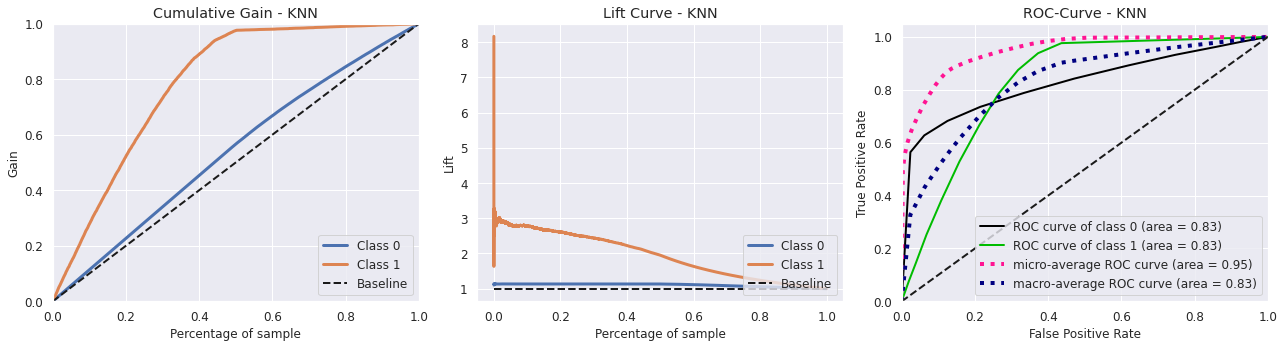

In [330]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axs[0],title='Cumulative Gain - KNN');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn,ax=axs[1],title='Lift Curve - KNN');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_knn, ax=axs[2], title='ROC-Curve - KNN');

plt.tight_layout()

## 8.2. Logistic Regression

In [14]:
# Model Definition
lr_model = lm.LogisticRegression(random_state=42)

# training model
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

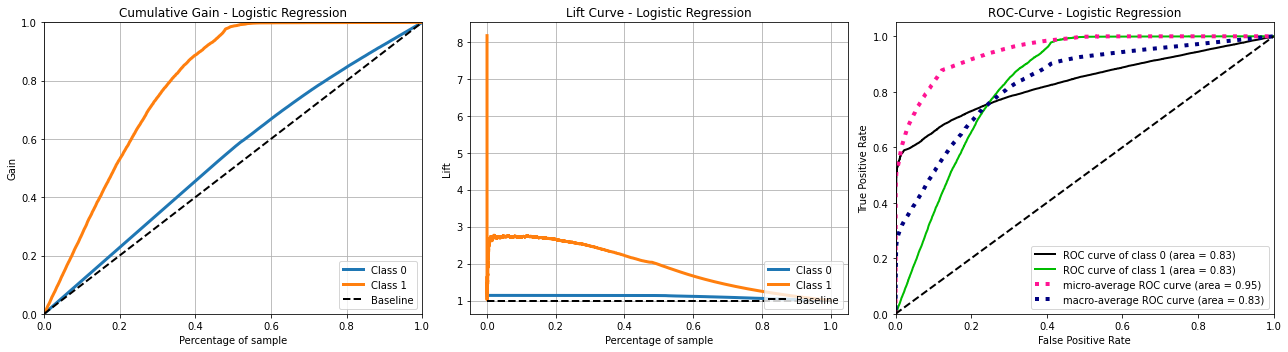

In [20]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr, ax=axs[0],title='Cumulative Gain - Logistic Regression');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr,ax=axs[1],title='Lift Curve - Logistic Regression');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_lr, ax=axs[2], title='ROC-Curve - Logistic Regression');

plt.tight_layout()

## 8.3. Random Forest

In [15]:
# Model Definition
rf_model = en.RandomForestClassifier(random_state=42)

# training model
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

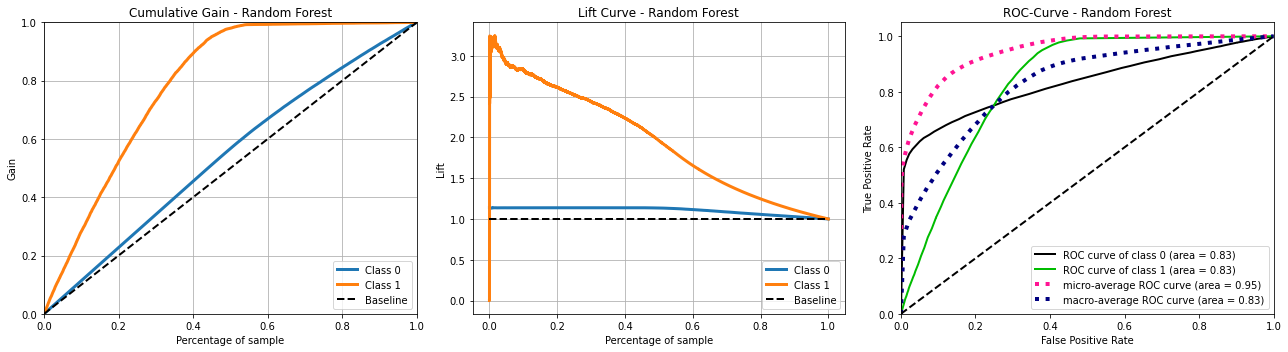

In [22]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf, ax=axs[0],title='Cumulative Gain - Random Forest');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf, ax=axs[1],title='Lift Curve - Random Forest');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_rf, ax=axs[2], title='ROC-Curve - Random Forest');

plt.tight_layout()

## 8.4. Adaboost

In [70]:
# Model Definition
adb_model = AdaBoostClassifier(random_state=42)

# training model
adb_model.fit(x_train, y_train)

# model prediction
yhat_adb = adb_model.predict_proba(x_val)

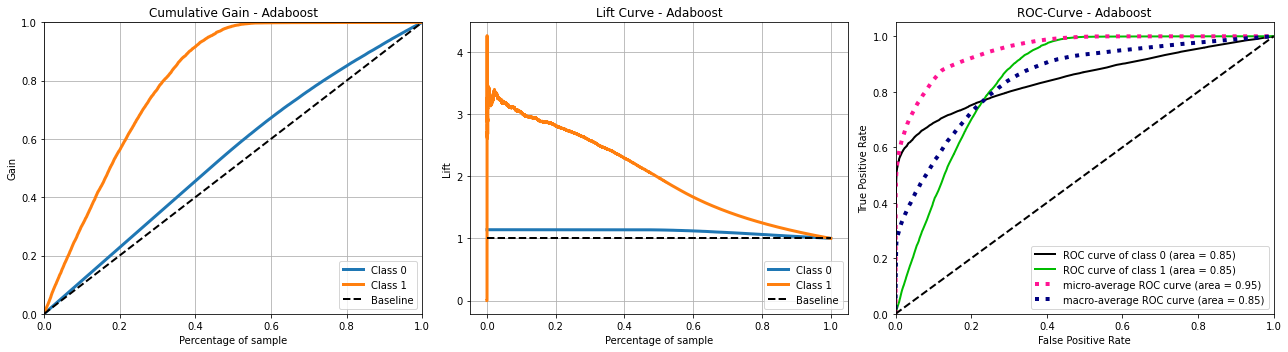

In [24]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_adb, ax=axs[0],title='Cumulative Gain - Adaboost');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_adb, ax=axs[1],title='Lift Curve - Adaboost');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_adb, ax=axs[2], title='ROC-Curve - Adaboost');

plt.tight_layout()

## 8.5. Bagging Classifier

In [17]:
# Model Definition
bgc_model = BaggingClassifier(random_state=42)

# training model
bgc_model.fit(x_train, y_train)

# model prediction
yhat_bgc = bgc_model.predict_proba(x_val)

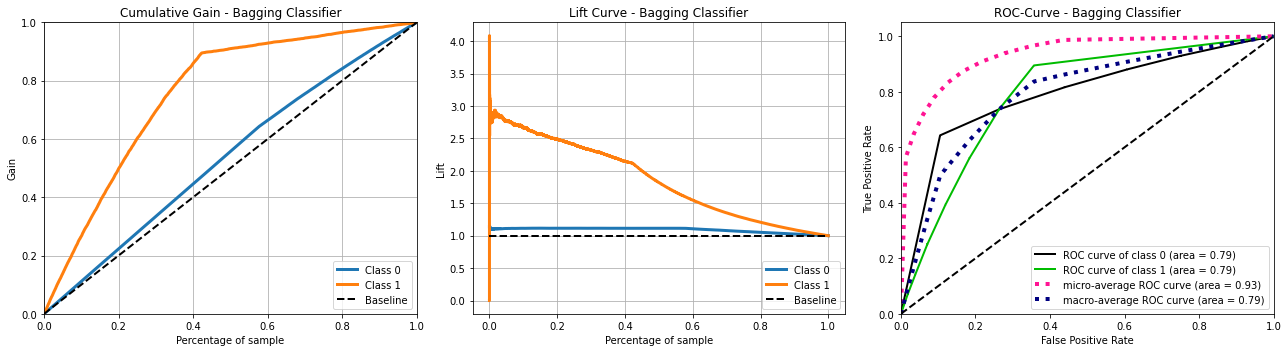

In [26]:
fig, axs = plt.subplots(ncols= 3, figsize = (18,5))

# cumulative gain - Metric for sorting problem
skplt.metrics.plot_cumulative_gain(y_validation, yhat_bgc, ax=axs[0],title='Cumulative Gain - Bagging Classifier');

# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_bgc, ax=axs[1],title='Lift Curve - Bagging Classifier');

# Roc Curve
skplt.metrics.plot_roc(y_validation, yhat_bgc, ax=axs[2], title='ROC-Curve - Bagging Classifier');

plt.tight_layout()

# 9.0. MODEL PERFORMANCE

## 9.1. Performance on Validation Dataset

In [18]:
# Copy data
df9_val = x_validation.copy()
df9_val = df9_val[cols_selected]
df9_val['response'] = y_validation.copy()

In [19]:
# dictionary with trained models
models = {'KNN': knn_model,
          'Logistic Regression': lr_model,
          'Random Forest': rf_model,
          'Adaboost': adb_model,
          'Bagging Classifier': bgc_model}

# Calculating Precision and Recall At k = 5,000
k = 5000
model_metrics = {}
for key in models.keys():
    df_scored = prediction_score(models[key], df9_val)
    model_metrics[key] = [df_scored.loc[k, 'precision_at_k'], df_scored.loc[k, 'recall_at_k']]

pd.DataFrame(model_metrics, index=['precision_at_k', 'recall_at_k']).T

,precision_at_k,recall_at_k
KNN,0.345531,0.148135
Logistic Regression,0.334333,0.143335
Random Forest,0.356729,0.152936
Adaboost,0.391122,0.167681
Bagging Classifier,0.338332,0.145049


## 9.2. Performance on Cross-Validation

In [20]:
# Concatenation train and validation dataset to use in cross-validation
df_cv = x_train.copy()
df_cv['response'] = y_train

df_aux = x_val.copy()
df_aux['response'] = y_validation

df_cv = pd.concat([df_cv, df_aux])

In [21]:
# Dictionary with models instantiated
models = {'KNN': knn_model,
          'Logistic Regression': lr_model,
          'Random Forest': rf_model,
          'Adaboost': adb_model,
          'Bagging Classifier': bgc_model}

# Cross-validated models performance
model_performance = pd.DataFrame()
for key in models.keys():
    performance_cv = cross_validation(5, key, models[key], df_cv, 5000)
    model_performance = pd.concat([model_performance, performance_cv], axis=1)

model_performance.T

,precision_at_k,std_precision,recall_at_k,std_recall
KNN,0.3445,+/-0.0033,0.1844,+/- 0.0018
Logistic Regression,0.3407,+/-0.0068,0.1824,+/- 0.0037
Random Forest,0.3520,+/-0.0023,0.1885,+/- 0.0012
Adaboost,0.3906,+/-0.005,0.2091,+/- 0.0027
Bagging Classifier,0.3354,+/-0.0073,0.1795,+/- 0.0039


- The metric that is best to the business problem is recall, as it tells us that of all interested customers, how many our model predicted right.
- With that, the best model is Adaboost

# 10.0. HYPERPARAMETER FINE TUNNING

In [29]:
x_df_cv = df_cv.drop(columns='response')
y_df_cv = df_cv['response']

In [43]:
adb_model_tunned = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
               'base_estimator__min_samples_leaf':[5,10],
               'n_estimators':[10,50,250,1000],
               'learning_rate':[0.01,0.1]}

clf = ms.RandomizedSearchCV(adb_model_tunned, parameters,n_iter=30, verbose=3,scoring='recall',n_jobs=-1, random_state=42)
clf.fit(x_df_cv,y_df_cv)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                                random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'base_estimator__max_depth': [2, 4, 6,
                                                                      8, 10],
                                        'base_estimator__min_samples_leaf': [5,
                                                                             10],
                                        'learning_rate': [0.01, 0.1],
                                        'n_estimators': [10, 50, 250, 1000]},
                   random_state=42, scoring='recall', verbose=3)

In [29]:
clf.best_params_

{'n_estimators': 250,
 'learning_rate': 0.1,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__max_depth': 10}

In [44]:
clf.best_params_

{'n_estimators': 1000,
 'learning_rate': 0.1,
 'base_estimator__min_samples_leaf': 5,
 'base_estimator__max_depth': 8}

## 10.1. Final Model

In [45]:
adb_model_tunned = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=5, max_depth=8),
                                     n_estimators=1000,
                                     learning_rate=0.1,
                                     random_state=42)

adb_final_performance = cross_validation(5, 'Adaboost_Tunned', adb_model_tunned, df_cv, 20000)

In [47]:
adb_final_performance

,Adaboost_Tunned
precision_at_k,0.3006 +/- 0.0026
recall_at_k,0.6435 +/- 0.0055


# 11.0. BUSINESS PERFORMANCE

## Business Assumption: Defining Cost-Benefit

- I'm going to assume the following scenario:
    - cost per phone call = BRL 100.00
    - profit per convertion: BRL 31,669.00 annualy (median annual premium)

In [154]:
n_calls = [20000, 40000]
cost_per_call = 100
profit_per_convertion = 31669 # median annual premium

## Baseline - Random calls

In [110]:
# calculating recall at 20.000 with random selection of the list
df9_val_indexes = np.asarray(data_scored.index)
indexes_20000 = np.random.choice(df9_val_indexes, 20000, replace=False)
df9_baseline_20000 = df9_val.iloc[indexes_20000]

recall_baseline_20000 = df9_baseline_20000['response'].sum() / data_scored['response'].sum()
print(f'Selecting 20.000 random clients to call, the marketing team would reach {recall_baseline_20000*100:.2f}% of interested clients')

#***************************************************************************************************

# calculating recall at 40.000 with random selection of the list
df9_val_indexes = np.asarray(data_scored.index)
indexes_40000 = np.random.choice(df9_val_indexes, 40000, replace=False)
df9_baseline_40000 = df9_val.iloc[indexes_40000]

recall_baseline_40000 = df9_baseline_40000['response'].sum() / data_scored['response'].sum()

print(f'Selecting 40.000 random clients to call, the marketing team would reach {recall_baseline_40000*100:.2f}% of interested clients')

Selecting 20.000 random clients to call, the marketing team would reach 20.42% of interested clients
Selecting 40.000 random clients to call, the marketing team would reach 41.52% of interested clients


In [155]:
# Calculating baseline profit with 20.000 calls
baseline_cost_20000 = n_calls[0] * cost_per_call
baseline_benefit_20000 = (df9_val['response'].sum()*recall_baseline_20000) * profit_per_convertion

profit_baseline_2000 = baseline_benefit_20000 - baseline_cost_20000
print(f'With 20,000 random calls, the baseline expected profit is BRL {profit_baseline_2000:,}')


# Calculating baseline profit with 40.000 calls

baseline_cost_40000 = n_calls[1] * cost_per_call
baseline_benefit_40000 = (df9_val['response'].sum()*recall_baseline_40000) * profit_per_convertion

profit_baseline_40000 = baseline_benefit_40000 - baseline_cost_40000
print(f'With 40,000 random calls, the baseline expected profit is BRL {profit_baseline_40000:,}')


With 20,000 random calls, the baseline expected profit is BRL 73,435,558.0
With 40,000 random calls, the baseline expected profit is BRL 149,372,967.0


## 11.1. Percentage of interested customers the sales team will be able to call with 20.000 calls;

In [166]:
# calculating percentage of interested customer reached by making 20.000 calls
data_scored = prediction_score(adb_model, df9_val)
recall_at_20000 = data_scored.loc[20000, 'recall_at_k']

# Calculating profit calling the top 20.000 clients
cost_20000 = n_calls[0] * cost_per_call
benefit_20000 = (df9_val['response'].sum()*recall_at_20000) * profit_per_convertion


profit_20000_calls = benefit_20000 - cost_20000

# comparing the baseline with the model performance
delta_20000 = profit_20000_calls - profit_baseline_2000

print(f'Calling the top 20.000 clients, the marketing team would reach {recall_at_20000*100:.2f}% of interested customers')
print(f'And the expected profit is BRL {profit_20000_calls:,}')
print(f'With the solution, the company would increase the profit by {delta_20000:,}, compared to the baseline')

Calling the top 20.000 clients, the marketing team would reach 58.52% of interested customers
And the expected profit is BRL 214,172,594.0
With the solution, the company would increase the profit by 140,737,036.0, compared to the baseline


## 11.2. Percentage of interested customers the sales team will be able to call with 40.000 calls;

In [168]:
# calculating percentage of interested customer reached by making 40.000 calls
data_scored = prediction_score(adb_model, df9_val)
recall_at_40000 = data_scored.loc[40000, 'recall_at_k']

# Calculating profit calling the top 40.000 clients
cost_40000 = n_calls[1] * cost_per_call
benefit_40000 = (df9_val['response'].sum()*recall_at_40000) * profit_per_convertion


profit_40000_calls = benefit_40000 - cost_40000

# comparing the baseline with the model performance
delta_40000 = profit_40000_calls - profit_baseline_40000

print(f'Calling the top 40.000 clients, the marketing team would reach {recall_at_40000*100:.2f}% of interested customers')
print(f'And the expected profit is BRL {profit_40000_calls:,}')
print(f'With the solution, the company would increase the profit by {delta_40000:,}, compared to the baseline')

Calling the top 40.000 clients, the marketing team would reach 93.71% of interested customers
And the expected profit is BRL 342,173,839.0
With the solution, the company would increase the profit by 192,800,872.0, compared to the baseline


## 11.3. How many calls the sales team have to make to reach 80% of the interested customers.

In [171]:
data_scored = prediction_score(adb_model, df9_val)
interested_80 = data_scored[data_scored['recall_at_k'] >= 0.8]['n_samples'].min()
print(f'The sales team would have to call {interested_80:,} customers to reach 80% of interested customers')

The sales team would have to call 30,097 customers to reach 80% of interested customers


# 12.0. MODEL DEPLOYMENT

In [71]:
# save trained model
#pickle.dump(adb_model, open('/home/kazu/Repos/pa004_health_insurance_cross_sell/src/trained_model/model_adaboost.pkl', 'wb'))

## Building HealthInsurance Class

In [10]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance(object):
    def __init__(self):
        self.home_path = '/home/kazu/Repos/pa004_health_insurance_cross_sell/'
        self.age_scaler = pickle.load(open(self.home_path + 'src/features/age_scaler.pkl', 'rb'))
        self.annual_premium_scaler = pickle.load(open(self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb'))
        self.delta_premium_by_region_scaler = pickle.load(open(self.home_path + 'src/features/delta_premium_by_region_scaler.pkl', 'rb'))
        self.median_premium_by_region_scaler = pickle.load(open(self.home_path + 'src/features/median_premium_by_region_scaler.pkl', 'rb'))
        self.policy_sales_channel_scaler = pickle.load(open(self.home_path + 'src/features/policy_sales_channel_scaler.pkl', 'rb'))
        self.region_code_scaler = pickle.load(open(self.home_path + 'src/features/region_code_scaler.pkl', 'rb'))
        self.vehicle_damage_region_code_scaler = pickle.load(open(self.home_path + 'src/features/vehicle_damage_region_code_scaler.pkl', 'rb'))
        self.vintage_scaler = pickle.load(open(self.home_path + 'src/features/vintage_scaler.pkl', 'rb'))
        self.ohc_gender_scaler = pickle.load(open(self.home_path + 'src/features/ohc_gender_scaler.pkl', 'rb'))
        self.vehicle_age_scaler = pickle.load(open('src/features/ohc_vehicle_age_scaler.pkl', 'rb'))
        self.vehicle_damage_scaler = pickle.load(open('src/features/ohc_vehicle_damage_scaler.pkl', 'rb'))

        
    def rename_columns(self, data):
        cols_new = {'id': 'id',
                    'Gender': 'gender',
                    'Age': 'age',
                    'Driving_License': 'driving_license',
                    'Region_Code': 'region_code',
                    'Previously_Insured': 'previously_insured',
                    'Vehicle_Age': 'vehicle_age',
                    'Vehicle_Damage': 'vehicle_damage',
                    'Annual_Premium': 'annual_premium',
                    'Policy_Sales_Channel': 'policy_sales_channel',
                    'Vintage': 'vintage'}
        
        data.rename(columns=cols_new, inplace=True)
        
        return data
        
    def feature_engineering(self, data):
        # median_premium_by_region

        # Calculating Median Annual Premium by Region_code
        dict_region_code = data[['annual_premium', 'region_code']].groupby('region_code').median().to_dict(orient='dict')['annual_premium']

        # Mapping region code to input median premium by region_code
        data['median_premium_by_region'] = data['region_code'].map(dict_region_code)

        # delta_annual_premium_by_region
        data['delta_premium_by_region'] = data['annual_premium'] - data['median_premium_by_region']

        # vehicle_damage percentage by region_code

        # percentage of vehicle_damage==1 by region_code
        perc_region_code = {}
        for i in data['region_code'].unique():
            perc_region_code[i] = ((data['vehicle_damage'] == 'Yes') & (data['region_code'] == i)).sum() / (data['region_code'] == i).sum()

        # Mapping region code to input percentage of vehicle_damage == Yes
        data['vehicle_damage_region_code'] = data['region_code'].map(perc_region_code)


        # discretize age (adult 1, adult 2, )
        data['age_discretized'] = data['age'].apply(lambda x: 'adult 1' if x<=39 else 
                                                                'adult 2' if x<=59 else
                                                                'old')
            
        return data
        
    def data_preparation(self, data):
        # annual_premium - StandardScaler
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)

        # age - MinMaxScaler
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage - MinMaxScaler
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        # delta_premium_by_region - MinMaxScaler
        data['delta_premium_by_region'] = self.delta_premium_by_region_scaler.transform(data[['delta_premium_by_region']].values)

        # gender - **One Hot Encoding**
        data['gender_Female'] = self.ohc_gender_scaler.transform(data[['gender']]).toarray()[:,0]
        data['gender_Male'] = self.ohc_gender_scaler.transform(data[['gender']]).toarray()[:,1]
        data.drop(columns='gender', inplace=True)

        # driving_license - already encoded (0 /1)

        # region_code - Frequency Encoding or **Target Encoding**
        data['region_code'] = data['region_code'].map(self.region_code_scaler)

        # previously_insured - already encoded (0 /1)

        # vehicle_age - **One Hot Encoding** / Frequency Encoding / Order Encoding
        data['vehicle_age_1-2 Year'] = self.vehicle_age_scaler.transform(data[['vehicle_age']]).toarray()[:,0]
        data['vehicle_age_< 1 Year'] = self.vehicle_age_scaler.transform(data[['vehicle_age']]).toarray()[:,1]
        data['vehicle_age_> 2 Years'] = self.vehicle_age_scaler.transform(data[['vehicle_age']]).toarray()[:,2]
        data.drop(columns='vehicle_age', inplace=True)

        # vehicle_damage **One Hot Encoding** / Frequency Encoding / Order Encoding
        data['vehicle_damage_No'] =  self.vehicle_damage_scaler.transform(data[['vehicle_damage']]).toarray()[:,0]
        data['vehicle_damage_Yes'] =  self.vehicle_damage_scaler.transform(data[['vehicle_damage']]).toarray()[:,1]
        data.drop(columns='vehicle_damage', inplace=True)

        # policy_sales_channel - Target Encoding / **Frequency Encoding**
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.policy_sales_channel_scaler)
        data['policy_sales_channel'].fillna(data['policy_sales_channel'].min(), inplace=True)

        # median_premium_by_region - **Frequency Encoding** or Target Encoding
        data['median_premium_by_region'] = data['median_premium_by_region'].map(self.median_premium_by_region_scaler)

        # vehicle_damage_region_code - **Frequency Encoding** or Target Encoding
        data['vehicle_damage_region_code'] = data['vehicle_damage_region_code'].map(self.vehicle_damage_region_code_scaler)

        cols_selected = ['vintage', 'annual_premium', 'age', 'vehicle_damage_Yes', 'policy_sales_channel',
                             'previously_insured', 'region_code', 'vehicle_age_< 1 Year', 'gender_Male']

        return data[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['score'] = pred[:, 1].tolist()
        
        return original_data.to_json(orient='records', date_format='iso')

## API Handler

In [10]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# load model
path = '/home/kazu/Repos/pa004_health_insurance_cross_sell/'
model = pickle.load(open(path+'src/trained_model/model_adaboost.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # feature engineering
        df1 = pipeline.rename_columns(test_raw)
        
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='applcation/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.0.17:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

## API Tester

In [331]:
import requests
import json

In [332]:
# loading test dataset
df_test = pd.read_csv('Data/test.csv', sep=',')
df_test = df_test.sample(30)

In [333]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [334]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-predict-score.herokuapp.com/predict'
      
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print(f'Status code {r.status_code}')

Status code 200


In [335]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False)

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,score
6,394155,0.215385,1,0.188545,0,-0.408517,0.017636,0.370242,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.498825
28,406103,0.261538,1,0.091969,0,-0.511940,0.194171,0.733564,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.496420
17,464857,0.569231,1,0.188545,0,-0.135729,0.209197,0.923875,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.496363
15,486500,0.430769,1,0.072823,0,-0.439000,0.209197,0.155709,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.496049
4,458529,0.323077,1,0.188545,0,0.898447,0.001620,0.920415,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.495484
11,402715,0.492308,1,0.188545,0,0.675983,0.194171,0.681661,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.495464
1,454084,0.138462,1,0.060481,0,-1.615701,0.027845,0.128028,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.494436
22,453552,0.615385,1,0.149123,0,0.025943,0.194171,0.930796,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.492788
9,490185,0.723077,1,0.121992,0,1.302944,0.194171,0.259516,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.492529
0,411557,0.707692,1,0.088387,0,0.328404,0.209197,0.698962,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.491952
